# Reanalysis of the extrusion data

In this notebook, I plan to add a few new elements to the extrusion data, namely:

1. new definition of the crossover from linear to nonlinear regime
2. correlation between exit temperature and the extrusion rate-force linearity
3. correlation between extrusion efficiency and the extrusion rate-force linearity

So clearly, we need to determine the linear regime first. 

## 0 Packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pandas as pd
from pathlib import Path

## 1 Determine linear regime

The original crossover was determined by fitting two lines to the linear regime and the nonlinear regime, and use the intersecting point as the crossover. However, since the nonlinear regime is not expected to be well-fitted by a line, this fitting could introduce arbitrariness to the analysis. 

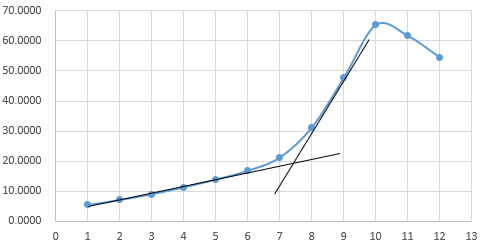

Here, I introduce an alternative approach, which does not rely on fitting the nonlinear regime. The basic work flow is to 
1. fit the first 3 points with a line, evaluate the mean error of the fit
2. if the mean error of the fit is below certain threshold, go on to fit the first 4 points, and evaluate the mean error
3. if the mean error is below the threshold continue to fit 5, 6, 7 points, until the mean error is greater than the threshold
4. use the number of points used as the linear regime. 

In [3]:
folder = r"H:\我的云端硬盘\Polymaker\003.挤出过程研究\003.挤出测试平台\实验数据\000.规范化数据（个人用）"
folder = Path(folder)

In [4]:
data = pd.read_excel(folder / "挤出测试平台数据.xlsx")

In [5]:
data

,速度,压力均值,压力标准差,压力均值.1,压力标准差.1,实际挤出量,设定挤出量,挤出效率,挤出效率校准,出口温度,设定温度,材料
0,1,0.5527,0.0920,5.41646,0.90160,101.40,100,1.014000,1.000000,190.0,190,L1002
1,2,0.7193,0.0153,7.04914,0.14994,202.75,200,1.013750,0.999753,189.0,190,L1002
2,3,0.9171,0.0169,8.98758,0.16562,303.53,300,1.011767,0.997798,188.0,190,L1002
3,4,1.1502,0.0209,11.27196,0.20482,404.22,400,1.010550,0.996598,186.0,190,L1002
4,5,1.4149,0.0281,13.86602,0.27538,503.92,500,1.007840,0.993925,183.0,190,L1002
...,...,...,...,...,...,...,...,...,...,...,...,...
284,11,2.4536,0.0930,24.04528,0.91140,1115.70,1100,1.014273,0.981586,NaN,250,Esun PLA
285,12,3.2790,0.1315,32.13420,1.28870,1207.14,1200,1.005950,0.973531,NaN,250,Esun PLA
286,13,4.2499,0.1512,41.64902,1.48176,1288.77,1300,0.991362,0.959413,NaN,250,Esun PLA
287,14,5.1143,1.0429,50.12014,10.22042,1352.23,1400,0.965879,0.934751,NaN,250,Esun PLA


In [6]:
df = data.loc[(data["材料"]=="L1002")&(data["设定温度"]==190)]
df

,速度,压力均值,压力标准差,压力均值.1,压力标准差.1,实际挤出量,设定挤出量,挤出效率,挤出效率校准,出口温度,设定温度,材料
0,1,0.5527,0.0920,5.41646,0.90160,101.40,100,1.014000,1.000000,190.0,190,L1002
1,2,0.7193,0.0153,7.04914,0.14994,202.75,200,1.013750,0.999753,189.0,190,L1002
2,3,0.9171,0.0169,8.98758,0.16562,303.53,300,1.011767,0.997798,188.0,190,L1002
3,4,1.1502,0.0209,11.27196,0.20482,404.22,400,1.010550,0.996598,186.0,190,L1002
4,5,1.4149,0.0281,13.86602,0.27538,503.92,500,1.007840,0.993925,183.0,190,L1002
5,6,1.7148,0.0331,16.80504,0.32438,603.81,600,1.006350,0.992456,180.0,190,L1002
6,7,2.1651,0.0559,21.21798,0.54782,701.15,700,1.001643,0.987813,178.0,190,L1002
7,8,3.1885,0.1373,31.24730,1.34554,795.04,800,0.993800,0.980079,177.0,190,L1002
8,9,4.8753,0.2334,47.77794,2.28732,869.12,900,0.965689,0.952356,179.0,190,L1002
9,10,6.6672,0.2741,65.33856,2.68618,905.45,1000,0.905450,0.892949,179.0,190,L1002


(0.0, 70.0)

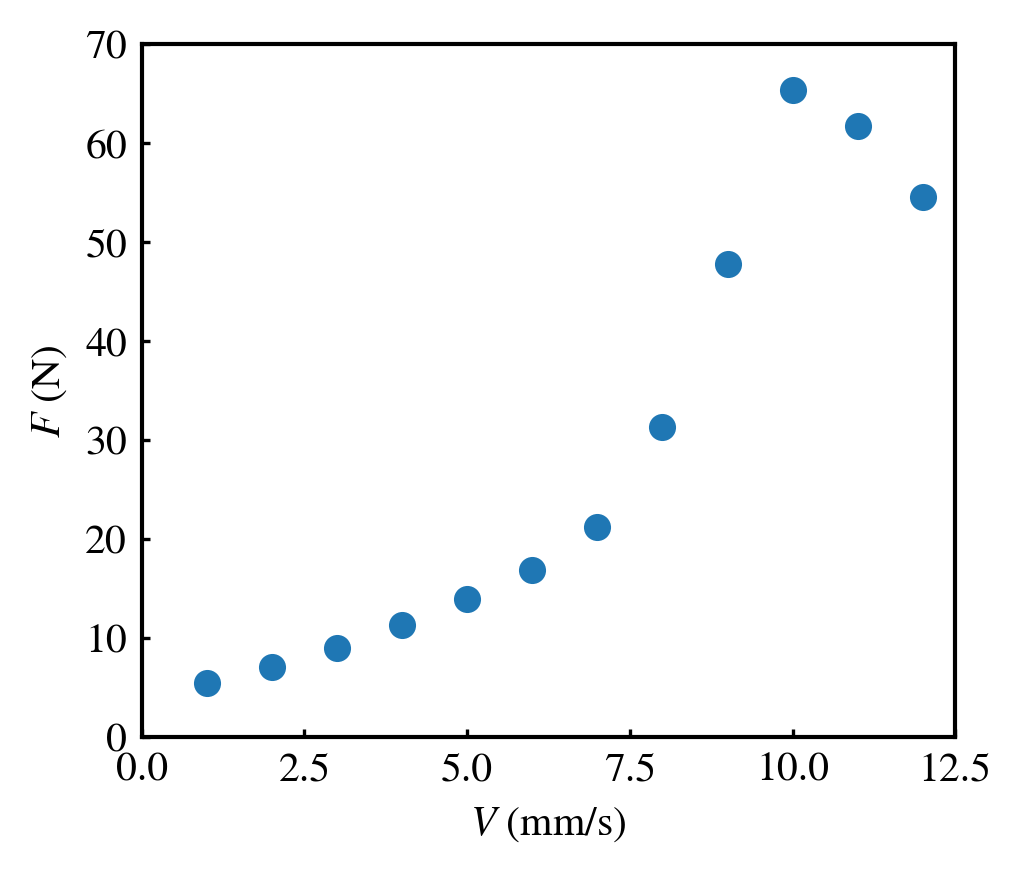

In [7]:
plt.figure(dpi=300)
plt.plot(df["速度"], df["压力均值.1"], "o")
plt.xlabel("$V$ (mm/s)")
plt.ylabel("$F$ (N)")
plt.xlim(0, 12.5)
plt.ylim(0, 70)

In [22]:
# define linear functions

def linear(x, a):
    return a * x
def linear_offset(x, a, b):
    return a * x + b

In [75]:
nPoints = 3
x = df["速度"][:nPoints]
y = df["压力均值.1"][:nPoints]

In [76]:

popt, pcov = curve_fit(linear_offset, x, y)

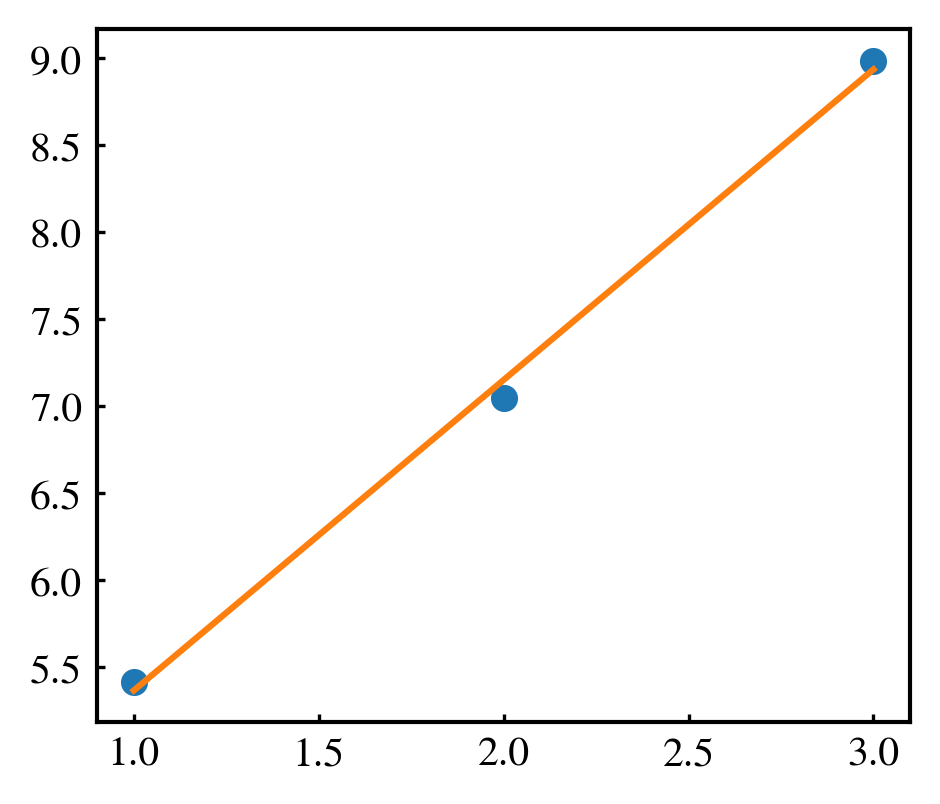

In [77]:
plt.plot(x, y, "o")
plt.plot(x, linear_offset(x, *popt))

In [78]:
mean_err = ((y - linear_offset(x, *popt)) ** 2).sum() / nPoints / np.mean(y)**2
mean_err

np.float64(0.00010156591617630314)

(0.0, 70.0)

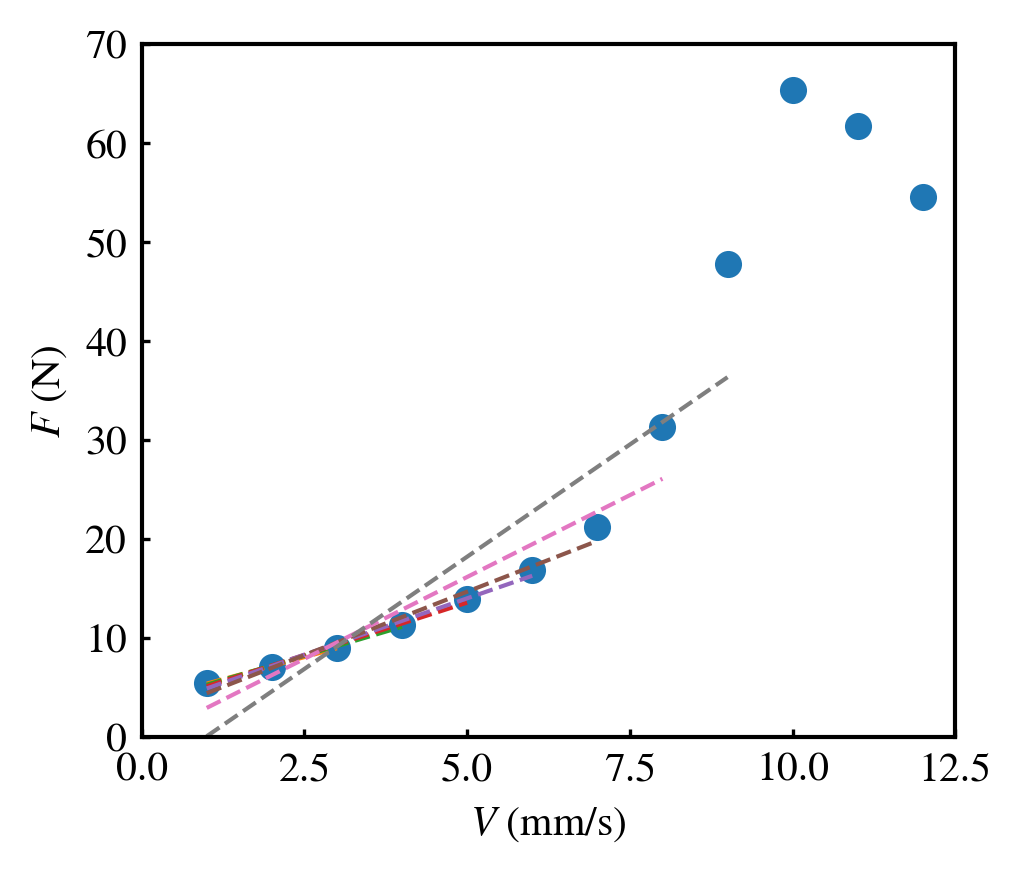

In [87]:
nPoints_list = range(3, 10)
mean_err_list = []
plt.plot(df["速度"], df["压力均值.1"], "o")
for nPoints in nPoints_list:
    x = df["速度"][:nPoints]
    y = df["压力均值.1"][:nPoints]
    popt, pcov = curve_fit(linear_offset, x, y)
    mean_err = ((y - linear_offset(x, *popt)) ** 2).sum() / nPoints / np.mean(y)**2
    plt.plot(x, linear_offset(x, *popt), lw=1, ls="--")
    mean_err_list.append(mean_err)
plt.xlabel("$V$ (mm/s)")
plt.ylabel("$F$ (N)")
plt.xlim(0, 12.5)
plt.ylim(0, 70)

Text(0, 0.5, 'Normalized mean square error, $\\left<\\delta y^2\\right>$')

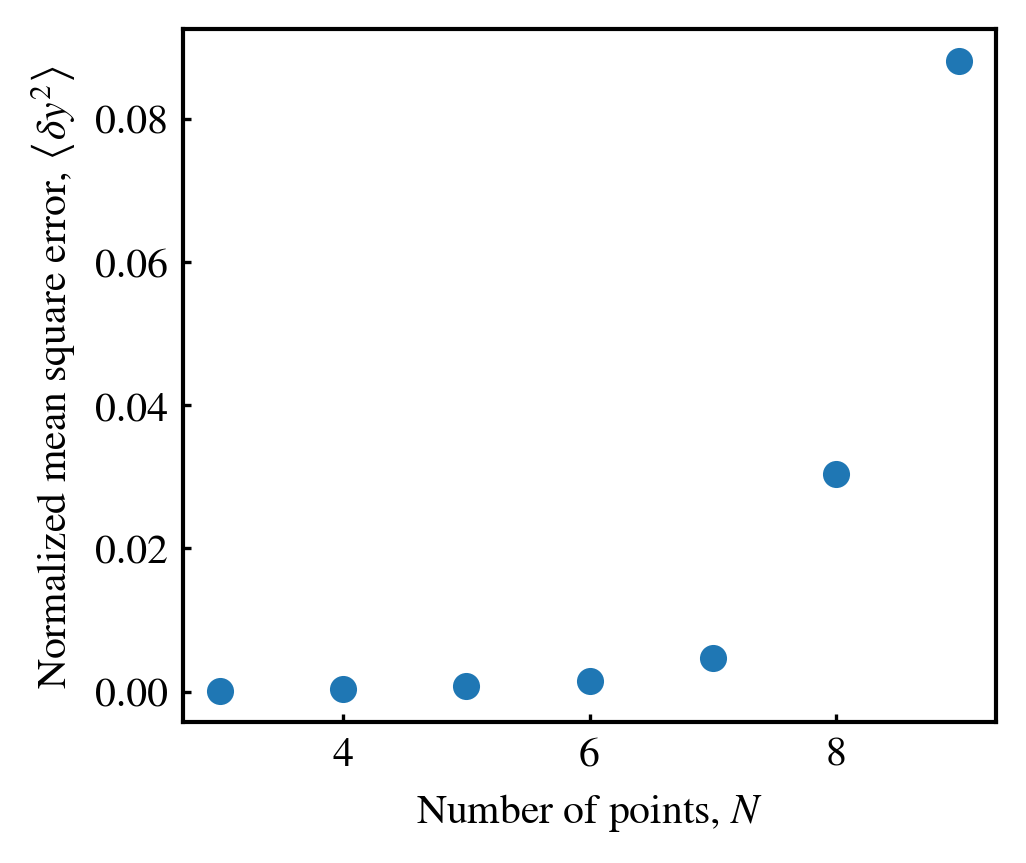

In [86]:
plt.plot(nPoints_list, mean_err_list, "o")
plt.xlabel("Number of points, $N$")
plt.ylabel("Normalized mean square error, $\\left<\\delta y^2\\right>$")

For the first data set, the procedure works fine, as we can clearly see a jump in the mean error between 7 points and 8 points. This suggests that the 